In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.models import Model, load_model
import cv2
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

import matplotlib as mpl
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
import glob
import re
from time import gmtime, strftime, sleep
mpl.rcParams['figure.figsize'] = (8.0, 4.0) 

In [2]:
def initialFocus(sid=1):
    cmD='rsh nvidia@10.42.0.90 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=1, pos=512):
    cmD='rsh nvidia@10.42.0.90 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=1, pos=512):
    cmD='rsh nvidia@10.42.0.90 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grabImage(sid=1, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rsh nvidia@10.42.0.90 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('rsh nvidia@10.42.0.90 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp nvidia@10.42.0.90:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    pop=skimage.transform.rotate(pop,180)
    return pop

In [12]:
def patchExtraction(sid = 1):
    I = grabImage()
    print(I.shape)

    I = skimage.color.rgb2gray(I)

    m, n= I.shape

    patch = I[m//2-256:m//2+256, n//2-256:n//2+256]
    patch = cv2.resize(patch, (0,0), fx=0.5, fy=0.5)
    patch = (patch - patch.min()) / (patch.max() - patch.min())
    return patch


In [13]:
initialFocus(sid=1)

b'sensor-id:1\nDemo Initialize\nDemo Start\nOIS Initilize\nEEPROM Read:\n  00 37 00 3B 01 C8 01 C0 FF 26 FF 9B 00 1B 00 1A \n  08 26 08 49 00 74 15 B8 17 20 29 24 D6 DC 20 00 \n  20 00 00 00 00 00 00 00 01 F1 10 00 00 01 00 01 \n  Gyro gain:5560(x1.00), 5920(x1.00)\nset: [Init:OIS] slave=1a, address=30ac, RegData = 01\n[Init:i2cdat_gyro]\nset: [Init:Start download] slave=3e, address=f010, RegData = 00\n[Init:DownloadProgram1]................................\n[Init:DownloadProgram2]....\n[Init:Calibration]\nset: [Init:Set OIS complete DL] slave=3e, address=f006, RegData = 00\nset: [Init:Servo on] slave=3e, address=6020, RegData = 01\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 02\nset: [Init:Gyro on] slave=3e, address=602c, RegData = 1b\nset: [Init:Gyro on] slave=3e, address=602d, RegData = 10\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 00\n[Init:GPO]\n[Init:PWM frequency]\nset: [OIS Hall current X] slave=3e, address=60a2, RegData = 37\nset: [OIS Hall current Y] sla

(2160, 3840, 3)
1.0


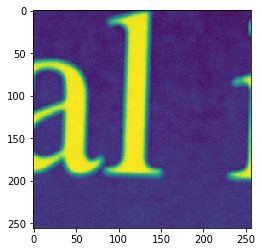

In [14]:
setFocus(sid=1, pos=1000)
patch = patchExtraction(sid = 1)
print(patch.max())
plt.imshow(patch)

In [15]:
input_image1 = Input(shape=(256,256,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(4, (8, 8), 8,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(8, (8, 8), 8,padding='same',activation=relu, name="Conv2_1")(layer1_1)

flattened = Flatten(name="flat")(layer2_1)
Dp1 = Dropout(0.5)(flattened)
dense1 = Dense(10, name="d1")(Dp1)
#ReLU1 = ReLU(name="lr1")(dense1)

output_position = Dense(1, activation='sigmoid', name="out")(dense1)

discriminator = Model(inputs=input_image1, outputs=output_position)
discriminator.load_weights('my_dis_weights.h5')

In [16]:
pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
print(pred)

0.9999931


In [17]:
model = load_model('my_model_step1.h5')

-0.20299715
(2160, 3840, 3)
-0.17223248
(2160, 3840, 3)
0.99999857
-0.2291455
(2160, 3840, 3)
-0.33768126
0.9999994
-0.33768126
(2160, 3840, 3)
-0.17174992
(2160, 3840, 3)
1.0
-0.40998772
(2160, 3840, 3)
-0.46415177
0.99999845
-0.46415177
(2160, 3840, 3)
-0.19502941


KeyboardInterrupt: 

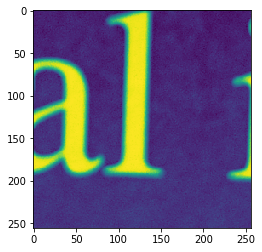

In [18]:
while (True):
    
    step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
    print(step)

    moveFocus(sid=1, pos=-step*100)

    patch = patchExtraction(sid = 1)
    plt.imshow(patch)

    temp = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
    print(temp)
    if temp < step:
        step = temp
        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
        print(pred)
        continue

    moveFocus(1, 200*step)
    patch = patchExtraction(sid = 1)
    plt.imshow(patch)
    pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
    print(pred)

In [9]:
step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]

In [10]:
print(step)

1.5100406
